In [1]:
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [40]:
embedding_dim = 25
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=1600000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []

In [41]:
import os
filefolder='C:\\Users\\liu1y\\Downloads\\glove'
filename='glove.twitter.27B.25d.txt'
fullname=os.path.join(filefolder, filename )

In [42]:
embeddings_index={}
f=open(os.path.join(filefolder, filename ), encoding='utf-8' )
for row in f:
    values=row.split()
    word=values[0]
    coefs=np.asarray(values[1:], dtype='float32')
    embeddings_index[word]=coefs
f.close()
print(f'found {len(embeddings_index)} word vectors.')

found 1193514 word vectors.


In [43]:
embeddings_index.popitem()

('ﾟﾟﾟｵﾔｽﾐｰ',
 array([-2.5807  , -1.0965  , -0.59056 ,  1.1178  , -0.30615 , -0.44198 ,
        -1.377   , -2.3494  ,  2.0436  , -0.15692 ,  2.6962  ,  1.033   ,
         0.81358 , -1.7224  ,  0.066939, -0.71714 ,  1.0608  , -0.43463 ,
         2.1178  ,  0.65876 ,  0.62825 , -1.2018  ,  1.7123  ,  0.79867 ,
         0.32424 ], dtype=float32))

In [44]:
num_sentences = 0
nRowsRead=1600000
filefolder2='C:\\Users\\liu1y\\Downloads\\training160K'
filename2='training.1600000.processed.noemoticon.csv'
fullname2=os.path.join(filefolder2, filename2 )
dataset=pd.read_csv(fullname2, encoding='latin', delimiter=',', header=None)
dataset.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [45]:
dataset.columns=['label', 'id','date','Q', 'name', 'sentences']
dataset.label.value_counts()

4    800000
0    800000
Name: label, dtype: int64

In [46]:
dataset.label[dataset.label>0]=1

<ipython-input-46-b82d9830c4e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.label[dataset.label>0]=1


In [47]:
dataset.label.value_counts()


1    800000
0    800000
Name: label, dtype: int64

In [48]:
sentences=[]
labels=[]
num_sentences=dataset.shape[0]
num_sentences
dataset=dataset.sample(frac=1)
sentences=dataset.sentences.to_list()
labels=dataset.label.to_list()

In [49]:
sentences[1]

'@CAKEZINNI u should feel 1000 thread count... i wish i thiefed them  we should go find some! hahaha'

In [50]:
#Tokenize the sentences
tokenizer=Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index=tokenizer.word_index
vocab_size=len(word_index)

In [51]:
print(f"vocabulary size is {vocab_size}")

vocabulary size is 690960


In [52]:
type(word_index)
word_index_items=word_index.items()

In [53]:
type(word_index_items)
first_few=list(word_index_items)[:5]
first_few

[('i', 1), ('to', 2), ('the', 3), ('a', 4), ('my', 5)]

In [54]:
sequences=tokenizer.texts_to_sequences(sentences)
padded=pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [55]:
type(padded)
padded.shape

(1600000, 16)

In [56]:
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]


In [57]:
print(vocab_size)
print(word_index['i'])


690960
1


In [58]:
embeddings_matrix=np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector=embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i]=embedding_vector;


In [59]:
print(len(embeddings_matrix))


690961


In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 25)            17274025  
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 25)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            8064      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 17,315,178
Trainable params: 41,153
Non-trainable params: 17,274,025
_____________________________________

KeyboardInterrupt: 

In [62]:
num_epochs = 5
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Epoch 1/5
45000/45000 - 210s - loss: 0.5195 - accuracy: 0.7365 - val_loss: 0.4922 - val_accuracy: 0.7545
Epoch 2/5
45000/45000 - 206s - loss: 0.5196 - accuracy: 0.7365 - val_loss: 0.4920 - val_accuracy: 0.7557
Epoch 3/5
45000/45000 - 232s - loss: 0.5192 - accuracy: 0.7366 - val_loss: 0.4912 - val_accuracy: 0.7558
Epoch 4/5
45000/45000 - 235s - loss: 0.5187 - accuracy: 0.7372 - val_loss: 0.4907 - val_accuracy: 0.7566
Epoch 5/5
45000/45000 - 229s - loss: 0.5187 - accuracy: 0.7372 - val_loss: 0.4909 - val_accuracy: 0.7568
Training Complete


In [61]:
model.get_weights()

[array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [-0.26079 ,  0.59108 ,  0.61622 , ...,  0.076869,  0.2284  ,
          0.2758  ],
        [ 0.28228 ,  0.019558,  0.11509 , ...,  0.2143  ,  0.25422 ,
         -0.26674 ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]], dtype=float32),
 array([[[ 1.74240196e+00, -3.39430064e-01,  2.12761700e-01, ...,
           6.27387226e-01,  7.75899515e-02,  2.02361703e+00],
         [-2.89752936e+00, -8.28644559e-02,  1.15489233e+00, ...,
          -1.11800706e+00, -1.69971657e+00,  2.56781638e-01],
         [ 4.53247994e-01,  6.29295230e-01, -1.23749733e+00, ...,
           5.55337965e-01, -9.70633328e-01, -1.89454901e+00],
         ...,
         [-1.70266557e+00,  2.64

<Figure size 432x288 with 0 Axes>

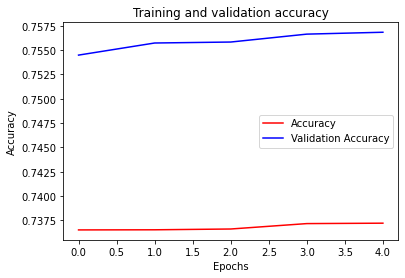

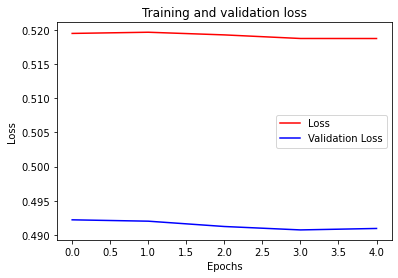

<Figure size 432x288 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()